# Analyze data downloaded from Google Takeout
https://takeout.google.com

See the blog here:
https://www.nurkiewicz.com/2020/03/see-how-google-is-tracking-your.html  

This notebook originally downloaded from   
https://github.com/nurkiewicz/google-location-history/blob/master/Google%20location%20history.ipynb


Download your location data from here https://takeout.google.com/ for your google account.
You can download lots of data but the analysis below only plots location. 
Export your location data in json format.

Anaconda should have most of the packages, but you must install these:  

    conda install geopandas
    conda install -c conda-forge descartes

In [6]:
import pandas as pd
import numpy as np
import geopandas as gp
import shapely.geometry as sg
import datetime as dt
from matplotlib import cm
from matplotlib.lines import Line2D

In [28]:
def extract_activity(record):
    try:
        return record["activity"][0]["activity"][0]["type"]
    except:
        return "MISSING"
    

def parse_json(json):
    ## had to expand this for some entries do not have the lat/long
    ## the expanded version is a lot slower that the list comprehension
    #points = [sg.Point(xy) for xy in zip(
    #    json.locations.apply(lambda x: x["longitudeE7"] / 10000000),
    #    json.locations.apply(lambda x: x["latitudeE7"] / 10000000)
    #)]

    pointsX = []
    pointsY = []
    for i,location in enumerate(json.locations):
#         if i==0:
#             print(location)
        if "longitudeE7" in location.keys() and "latitudeE7" in location.keys():
            pointsX.append(location["longitudeE7"] / 10000000)
            pointsY.append(location["latitudeE7"] / 10000000)
    points = [sg.Point(xy) for xy in zip(pointsX,pointsY)]
    df = gp.GeoDataFrame(geometry=points)
    
    locations = json.locations
    df["timestamp"] = locations.apply(lambda x: pd.to_datetime(x["timestampMs"], unit='ms'))
    
    # my data file contains locations without some of these attributes, so just leave them out
#     df["accuracy"] = locations.apply(lambda x: x["accuracy"])
#     df["velocity"] = locations.apply(lambda x: x.get("velocity", None))
#     df["heading"] = locations.apply(lambda x: x.get("heading", None))
#     df["altitude"] = locations.apply(lambda x: x.get("altitude", None))
#     df["activity"] = locations.apply(extract_activity)

    return df

In [29]:
%time df = parse_json(pd.read_json("./data/LocationHistory.json"))
df.shape

Wall time: 2min 24s


(597903, 2)

In [31]:
# http://thematicmapping.org/downloads/world_borders.php
world = gp.read_file('./data/TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp')

In [32]:
def compute_legend(df, ax, cmap, steps):
    vals = [x / (steps - 1) for x in range(steps)]
    custom_lines = [Line2D([0], [0], color=cmap(step), lw=4) for step in vals]
    labels = [df.timestamp.quantile(step).strftime("%Y-%m-%d") for step in vals]
    ax.legend(custom_lines, labels, loc="lower right")
    

def seconds(timestamp):
    return timestamp.to_pydatetime().timestamp()


def calculate_pal(df2, cmap):
    min_ts = seconds(df2.timestamp.min())
    max_ts = seconds(df2.timestamp.max())
    return df2.timestamp.apply(lambda ts: cmap((seconds(ts) - min_ts) / (max_ts - min_ts))).tolist()


def draw_map(df, box):
    box_only = df[df.geometry.within(box)]
    minx, miny, maxx, maxy = box.bounds
    base = world.plot(color='white', edgecolor='silver', figsize=(16,12))
    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    cmap = cm.get_cmap('viridis')
    pal = calculate_pal(box_only, cmap)
    ax = box_only.plot(ax=base, marker='o', color=pal, markersize=8)
    compute_legend(box_only, ax, cmap, 5)

# World

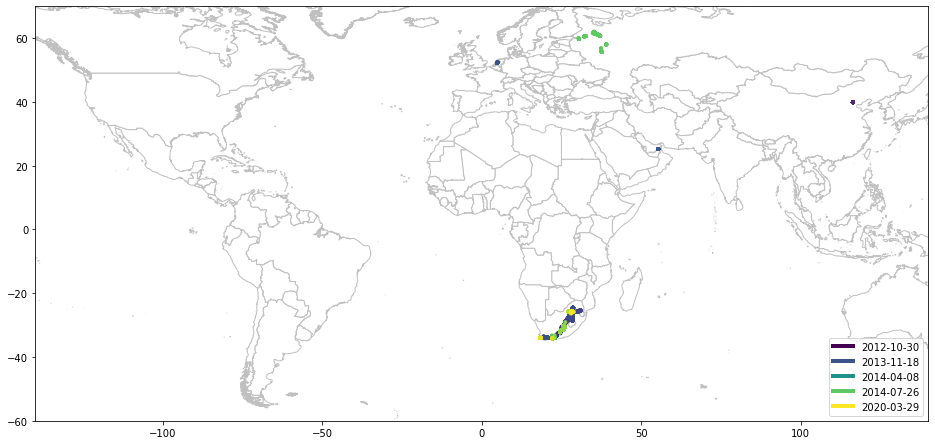

In [34]:
draw_map(df, sg.box(-140, -60, 140, 70))

# South Africa

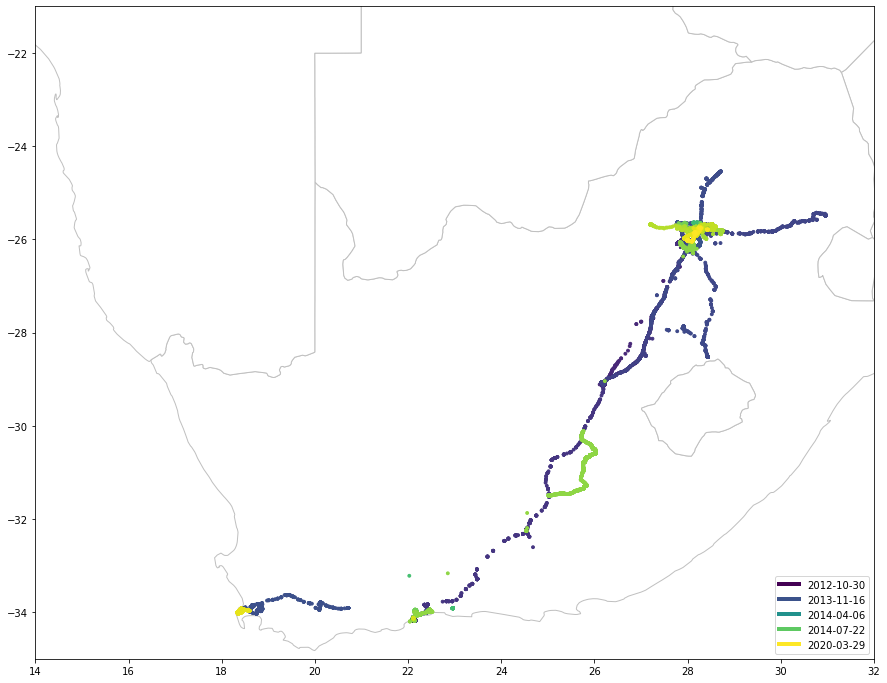

In [36]:
draw_map(df, sg.box(14, -35, 32, -21))

# Gauteng and surrounds

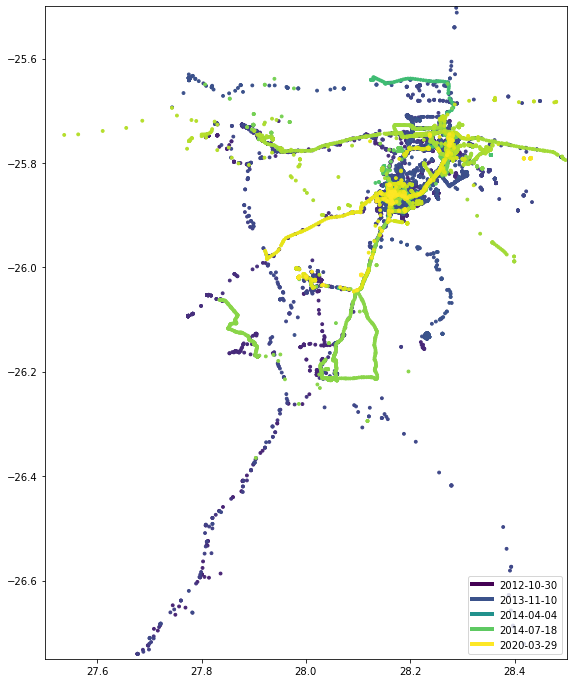

In [38]:
draw_map(df, sg.box(27.5, -26.75, 28.75, -25.0))

# Pretoria & Johannesburg

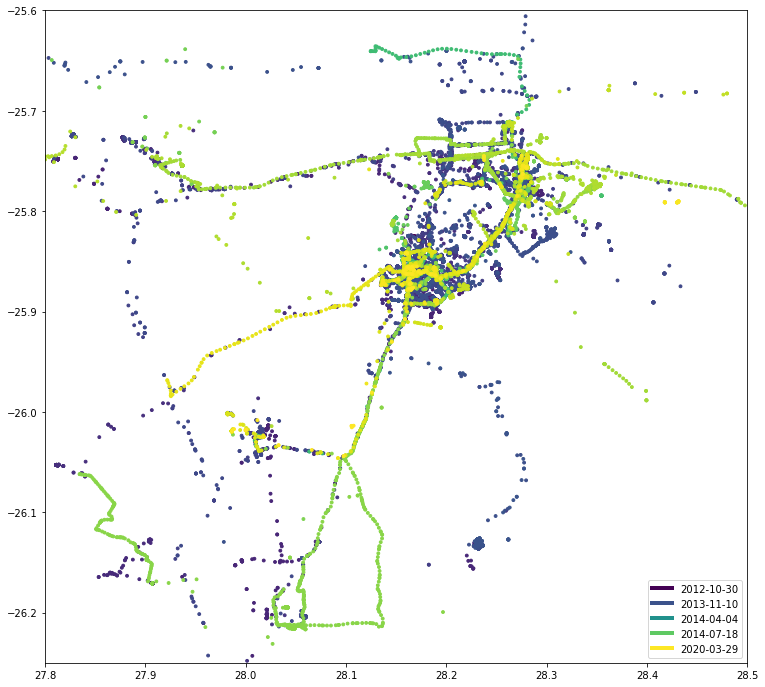

In [43]:
draw_map(df, sg.box(27.8, -26.25, 28.5, -25.60))

# Pretoria

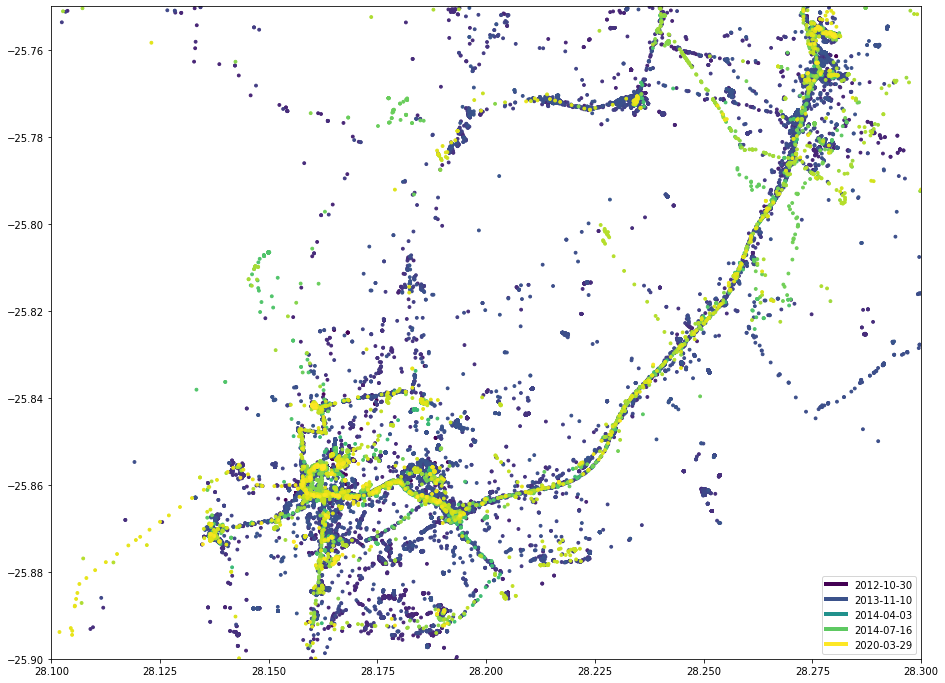

In [41]:
draw_map(df, sg.box(28.1, -25.9, 28.3, -25.75))